In [92]:
from os import environ
from collections import Counter
import random
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
from wordcloud import WordCloud

from medleydb.utils import get_instrument_stems, get_instruments_list, get_instrument_tracks, get_track_instruments

#### Create the environnement variables

In [4]:
# %env...

env: MEDLEYDB_PATH=/media/mvitry/7632099B3209620B/Mickaël/Documents/MIR/Medley/MedleyDB/V1+2
env: METADATA_PATH=/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata


In [5]:
wd_path = Path.cwd() # working directory
data_path = wd_path.joinpath("data") # data directory containing the metadata.csv
img_path = wd_path.joinpath('images') # images from the data visualizations

metadata_path = Path(environ['METADATA_PATH']) # medleyDB repo data path

audio_path = Path(environ['MEDLEYDB_PATH']) # medleyDB audio files path

print("wd: {},\ndata: {},\nmedleydb data: {},\naudio: {},\nimages: {}".format(wd_path, data_path, metadata_path, audio_path, img_path))

wd: /home/mvitry/Dev/jedha-final-project/medleydb,
data: /home/mvitry/Dev/jedha-final-project/medleydb/data,
medleydb data: /media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata,
audio: /media/mvitry/7632099B3209620B/Mickaël/Documents/MIR/Medley/MedleyDB/V1+2,
images: /home/mvitry/Dev/jedha-final-project/medleydb/images


### Listing the audio files of the dataset

In [11]:
audio_files = [a.name for a in audio_path.iterdir() if a.is_dir()]

In [12]:
audio_files[:5]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain']

### Listing the metadata files (yaml)

In [17]:
metadata_files = [m for m in metadata_path.glob('*.yaml')]
metadata_files[:5]

[PosixPath('/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata/LynyrdSkynyrd_FreeBird_METADATA.yaml'),
 PosixPath('/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata/AcDc_BackInBlack_METADATA.yaml'),
 PosixPath('/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata/AClassicEducation_NightOwl_METADATA.yaml'),
 PosixPath('/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata/Adele_SomeoneLikeYou_METADATA.yaml'),
 PosixPath('/media/mvitry/7632099B3209620B/github/medleydb-theo/medleydb/data/Metadata/Aerosmith_LoveInAnElevator_METADATA.yaml')]

In [18]:
metadata_filenames = [m.name.split("_METADATA")[0] for m in metadata_files]
metadata_filenames[:5]

['LynyrdSkynyrd_FreeBird',
 'AcDc_BackInBlack',
 'AClassicEducation_NightOwl',
 'Adele_SomeoneLikeYou',
 'Aerosmith_LoveInAnElevator']

In [19]:
match = [m for m in metadata_files if m.name.split("_METADATA")[0] in audio_files]

In [20]:
len(match)

196

### Creating a dataframe from the audio metadata files

In [6]:
metadata_df = pd.read_csv(data_path.joinpath("metadata.csv"), index_col=0)

### Script to create the dataframe from the yaml metadata files

````python
metadata_df = pd.DataFrame()

for f in match:
    with open(f, 'r') as stream:
        m = pd.json_normalize(yaml.load(stream, Loader=yaml.FullLoader), max_level=0)
    metadata_df = metadata_df.append(m, ignore_index=True)

metadata_df.to_csv(data_path.joinpath("metadata.csv"))
````

In [25]:
metadata_df.head()

album               artist                 composer  \
0  Shaking Through Volume 2  A Classic Education  ['A Classic Education']   
1                       NaN        Aimee Norwich        ['Aimee Norwich']   
2                       NaN        Aimee Norwich        ['Aimee Norwich']   
3                       NaN       Alexander Ross       ['Alexander Ross']   
4                       NaN       Alexander Ross       ['Alexander Ross']   

  excerpt              genre has_bleed instrumental  \
0      no  Singer/Songwriter        no           no   
1      no  Singer/Songwriter        no           no   
2      no         World/Folk        no          yes   
3      no  Singer/Songwriter        no           no   
4      no  Singer/Songwriter        no           no   

                          mix_filename              origin  \
0   AClassicEducation_NightOwl_MIX.wav   Weathervane Music   
1           AimeeNorwich_Child_MIX.wav  Independent Artist   
2          AimeeNorwich_Flying_MIX.wav  Independent Artist   
3  AlexanderRoss_GoodbyeBolero_MIX.wav  Independent Artist   
4  AlexanderRoss_VelvetCurtain_MIX.wav  Independent Artist   

                           producer                          raw_dir  \
0                 ['Andy Williams']   AClassicEducation_NightOwl_RAW   
1  ['Aimee Norwich & Senem Pirler']           AimeeNorwich_Child_RAW   
2  ['Aimee Norwich & Senem Pirler']          AimeeNorwich_Flying_RAW   
3                  ['Mike Tierney']  AlexanderRoss_GoodbyeBolero_RAW   
4                  ['Mike Tierney']  AlexanderRoss_VelvetCurtain_RAW   

                            stem_dir  \
0   AClassicEducation_NightOwl_STEMS   
1           AimeeNorwich_Child_STEMS   
2          AimeeNorwich_Flying_STEMS   
3  AlexanderRoss_GoodbyeBolero_STEMS   
4  AlexanderRoss_VelvetCurtain_STEMS   

                                               stems           title  version  \
0  {'S01': {'component': 'bass', 'filename': 'ACl...       Night Owl      1.2   
1  {'S01': {'component': '', 'filename': 'AimeeNo...           Child      1.2   
2  {'S01': {'component': '', 'filename': 'AimeeNo...          Flying      1.2   
3  {'S01': {'component': '', 'filename': 'Alexand...  Goodbye Bolero      1.2   
4  {'S01': {'component': 'melody', 'filename': 'A...  Velvet Curtain      1.2   

                                        website  
0  ['www.shakingthrough.com/aclassiceducation']  
1                      ['www.aimeenorwich.com']  
2                      ['www.aimeenorwich.com']  
3                                            []  
4                                            []

### Listing all unique instruments

In [31]:
# on parcours tous les stems et on ajoute les instruments à la liste
instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        instruments_list.append(s["instrument"])
instruments_list = list(sorted(set(instruments_list)))

In [32]:
instruments_list[:10]

['Main System',
 'accordion',
 'acoustic guitar',
 'alto saxophone',
 'auxiliary percussion',
 'bamboo flute',
 'banjo',
 'baritone saxophone',
 'bass clarinet',
 'bass drum']

### Creating a dictionnary of instrument, useful to rename the audio files in the preprocessing

In [33]:
instruments_dict = {i: i.replace(' ', '_') for i in instruments_list}
instruments_dict

{'Main System': 'Main_System',
 'accordion': 'accordion',
 'acoustic guitar': 'acoustic_guitar',
 'alto saxophone': 'alto_saxophone',
 'auxiliary percussion': 'auxiliary_percussion',
 'bamboo flute': 'bamboo_flute',
 'banjo': 'banjo',
 'baritone saxophone': 'baritone_saxophone',
 'bass clarinet': 'bass_clarinet',
 'bass drum': 'bass_drum',
 'bassoon': 'bassoon',
 'bongo': 'bongo',
 'brass section': 'brass_section',
 'castanet': 'castanet',
 'cello': 'cello',
 'cello section': 'cello_section',
 'chimes': 'chimes',
 'claps': 'claps',
 'clarinet': 'clarinet',
 'clarinet section': 'clarinet_section',
 'clean electric guitar': 'clean_electric_guitar',
 'cymbal': 'cymbal',
 'darbuka': 'darbuka',
 'distorted electric guitar': 'distorted_electric_guitar',
 'dizi': 'dizi',
 'double bass': 'double_bass',
 'doumbek': 'doumbek',
 'drum machine': 'drum_machine',
 'drum set': 'drum_set',
 'electric bass': 'electric_bass',
 'electric piano': 'electric_piano',
 'electronic organ': 'electronic_organ',


### Counting the occurences of instruments

In [7]:
# for each track, read the stems intruments and add to instrument counter
instrument_counter = {}
for track in metadata_df["stems"]:
    # get the instrument list of a track
    track_instruments = get_track_instruments(track)
    for i in track_instruments:
        if i in instrument_counter:
            instrument_counter[i] += 1
        else:
            instrument_counter[i] = 1
# for each instrument of the list increment the instrument counter

In [36]:
instruments_df = pd.DataFrame.from_dict(instrument_counter, orient="index", columns=["Occurence"]).sort_values(by="Occurence", ascending=False)

In [37]:
instruments_df.head()

Occurence
drum set                     106
electric bass                 84
piano                         72
clean electric guitar         53
male singer                   50

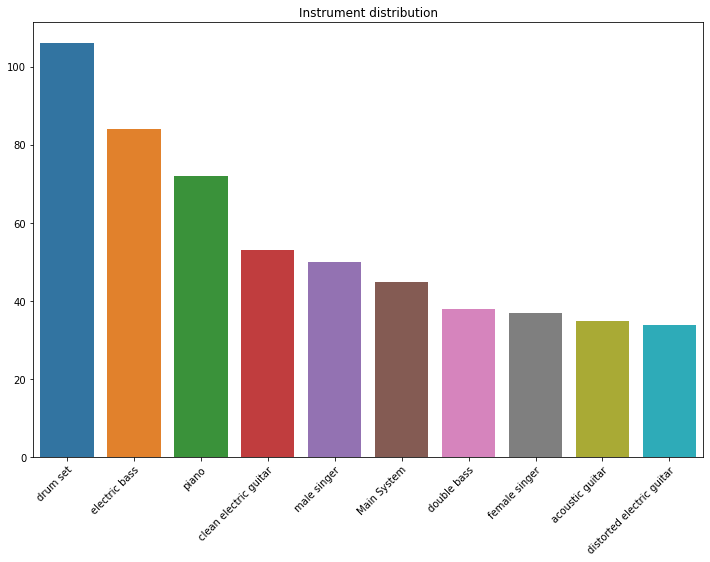

In [53]:
top_instruments = instruments_df[:10].T

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=top_instruments, ax=ax)
ax.set_title("Instrument distribution")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()
#fig.savefig(img_path.joinpath('dist_instrument.png'), transparent=False, dpi=80, bbox_inches="tight")

### Wordcloud of instruments

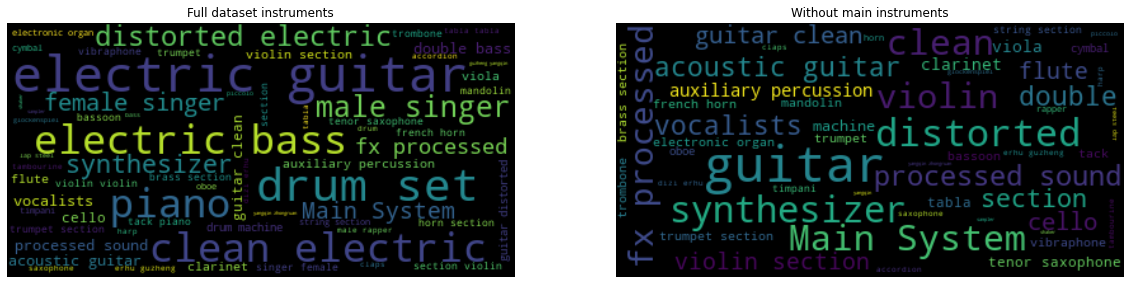

In [98]:
full_instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        full_instruments_list.append(s["instrument"])

text = " ".join(full_instruments_list)

wordcloud = WordCloud(max_font_size=40).generate(text)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].imshow(wordcloud, interpolation="bilinear")
axs[0].set_title("Full dataset instruments")
axs[0].axis("off")

STOP_WORDS = ["drum", "set", "electric", "bass", "piano", "male", "female", "singer"]

wordcloud = WordCloud(max_font_size=40, stopwords=STOP_WORDS).generate(text)
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].set_title("Without main instruments")
axs[1].axis("off")

plt.show()

### Wordcloud of genres

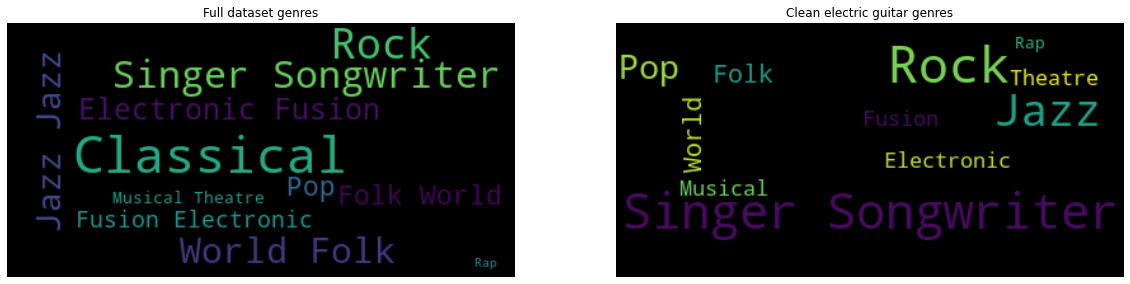

In [121]:
text = " ".join(metadata_df["genre"].values)

wordcloud = WordCloud(max_font_size=40).generate(text)

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].imshow(wordcloud, interpolation="bilinear")
axs[0].set_title("Full dataset genres")
axs[0].axis("off")

clean_el_guitar_tracks = get_instrument_tracks(get_instrument_stems(metadata_df["stems"], "clean electric guitar"), "clean electric guitar")
text = ""
for genre, track in zip(metadata_df["genre"], metadata_df["stem_dir"]):
    if track.split("_STEM")[0] in clean_el_guitar_tracks:
        text += " " + genre

wordcloud = WordCloud(max_font_size=40).generate(text)
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].set_title("Clean electric guitar genres")
axs[1].axis("off")

plt.show()

### Listing the TRACKS containing STEMS with a specific instrument

In [63]:
clean_el_guitar_stems = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        if s["instrument"] == "clean electric guitar":
            clean_el_guitar_stems.append(s["filename"])
clean_el_guitar_stems = sorted(clean_el_guitar_stems)
clean_el_guitar_stems[:10]

['AClassicEducation_NightOwl_STEM_05.wav',
 'AimeeNorwich_Child_STEM_03.wav',
 'AimeeNorwich_Flying_STEM_04.wav',
 'AimeeNorwich_Flying_STEM_05.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_02.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_02.wav',
 'AlexanderRoss_VelvetCurtain_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_10.wav',
 'AmarLal_Rest_STEM_01.wav']

### Listing the TRACKS containing a specific instrument

In [56]:
clean_el_guitar_tracks = list(sorted(set([s.split("_STEM")[0] for s in clean_el_guitar_stems])))
clean_el_guitar_tracks[:10]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain',
 'AmarLal_Rest',
 'Auctioneer_OurFutureFaces',
 'CelestialShore_DieForUs',
 'ChrisJacoby_BoothShotLincoln',
 'ClaraBerryAndWooldog_AirTraffic']

### Clean electric guitar dataset statistics

In [88]:
# lenghts of the tracks
track_lengths = []
for track in clean_el_guitar_tracks:
    track_path = audio_path.joinpath(track, track + "_MIX.wav")
    try:
        track_lengths.append(librosa.get_duration(filename=track_path))
    except:
        print(f"Error reading: {track_path}")
print()     
# number of tracks
print(f"Number of tracks containing 'clean electric guitar': {len(clean_el_guitar_tracks)}")    
print(f"Total duration: {sum(track_lengths)/3600:.2f} hours")

Error reading: /media/mvitry/7632099B3209620B/Mickaël/Documents/MIR/Medley/MedleyDB/V1+2/AimeeNorwich_Child/AimeeNorwich_Child_MIX.wav

Number of tracks containing 'clean electric guitar': 53
Total duration: 4.06 hours


### Focusing on the COMPONENT value of the STEMS

In [39]:
components_solo = []
stems_solo = []

for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        components_solo.append(s["component"])
        stems_solo.append(s["filename"])

In [40]:
liste_components = []
stems_compo = zip(stems_solo, components_solo)
stems_compo = list(stems_compo)

for s in stems_compo :
    for c in clean_el_guitar_stems :
        if s[0] == c :
            liste_components.append(s[1])

In [41]:
results = zip(clean_el_guitar_stems, liste_components)
results = list(results)
Counter(liste_components)

Counter({'': 51, 'melody': 29})

### Focusing on whether or not the TRACKS  has bleed
Since all the stems audio sources were not totally isolated from each other during the recording

In [42]:
mix_cible = []
clean_el_guitar_tracks = list(clean_el_guitar_tracks)

for i in clean_el_guitar_tracks :
    mix_cible.append(i+('_MIX.wav'))

In [43]:
has_bleed = []
has_mix = zip(metadata_df['mix_filename'], metadata_df['has_bleed'])
has_mix = list(has_mix)

for i in has_mix :
    for j in mix_cible :
        if i[0] == j :
            has_bleed.append(i[1])

In [45]:
results_bleed = zip(mix_cible, has_bleed)
results_bleed = sorted(list(results_bleed))
results_bleed[:10]

[('AClassicEducation_NightOwl_MIX.wav', 'no'),
 ('AimeeNorwich_Child_MIX.wav', 'no'),
 ('AimeeNorwich_Flying_MIX.wav', 'no'),
 ('AlexanderRoss_GoodbyeBolero_MIX.wav', 'no'),
 ('AlexanderRoss_VelvetCurtain_MIX.wav', 'no'),
 ('AmarLal_Rest_MIX.wav', 'no'),
 ('Auctioneer_OurFutureFaces_MIX.wav', 'no'),
 ('CelestialShore_DieForUs_MIX.wav', 'no'),
 ('ChrisJacoby_BoothShotLincoln_MIX.wav', 'yes'),
 ('ClaraBerryAndWooldog_AirTraffic_MIX.wav', 'no')]

### Data visualization

In [46]:
liste_components = [i.replace('melody', '1') for i in liste_components]
df1 = pd.DataFrame(liste_components) 

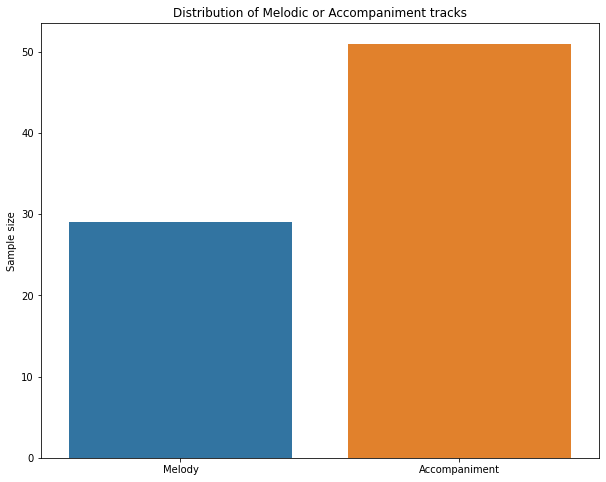

In [55]:
# 11 tracks are in melody, 45 are in accompaniment.

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=df1.value_counts(), y=df1.value_counts(), ax=ax).set_title('Distribution of Melodic or Accompaniment tracks')
ax.set_ylabel("Sample size")
ax.set_xticklabels(["Melody","Accompaniment"])

plt.show()

In [57]:
has_bleed = [i.replace('yes', '1') for i in has_bleed]
has_bleed = [i.replace('no', '0') for i in has_bleed]
df = pd.DataFrame(has_bleed) 

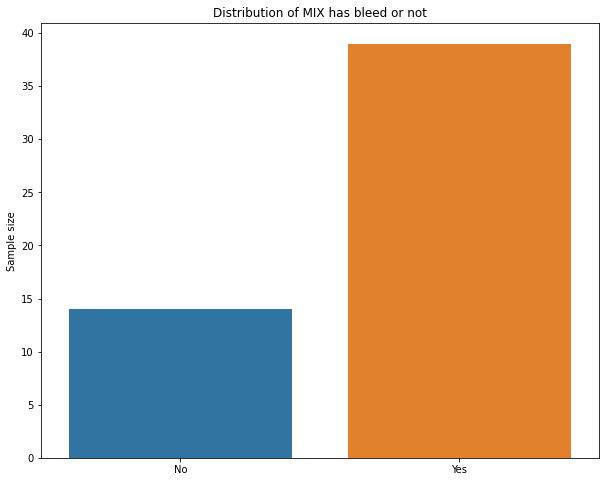

In [59]:
# 32 MIX aren't bleed, 4 MIX are.

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=df.value_counts(), y=df.value_counts(), ax=ax).set_title("Distribution of MIX has bleed or not")
ax.set_ylabel("Sample size")
ax.set_xticklabels(["No","Yes"])

plt.show()
# save(img_path.joinpath("mon_graphe.png"))

### Spectrum modeling with the librosa library

In [8]:
# We get 2 lists to be able to compare the spectra of these 2 types of guitars

electric_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'clean electric guitar')
acoustic_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'acoustic guitar')

In [9]:
# Recreate the path to the track chooses randomly

electric_choice = random.choices(electric_stems, k = 3)
print("Our 3 tracks are : ", electric_choice)
clean_sampling_electric = ([s.split("_STEM")[0] for s in electric_choice])
clean_sampling_chiffre_electric = ([s.split("_0")[0] for s in electric_choice])

Our 3 tracks are :  ['DeadMilkmen_PrisonersCinema_STEM_09.wav', 'MusicDelta_Britpop_STEM_06.wav', 'MusicDelta_Country2_STEM_04.wav']


In [11]:
clean_sampling_chiffre_electric

['DeadMilkmen_PrisonersCinema_STEM',
 'MusicDelta_Britpop_STEM',
 'MusicDelta_Country2_STEM']

In [62]:
liste_pistes_electric = []
for i in range(0,3) :
    add_electric = Path.joinpath(audio_path, clean_sampling_electric[i], (clean_sampling_chiffre_electric[i])+'S', electric_choice[i])
    liste_pistes_electric.append(add_electric)

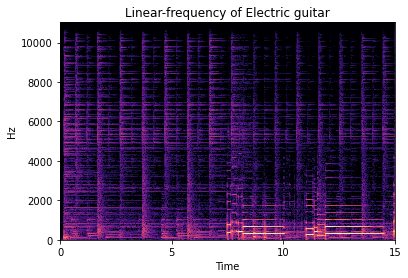

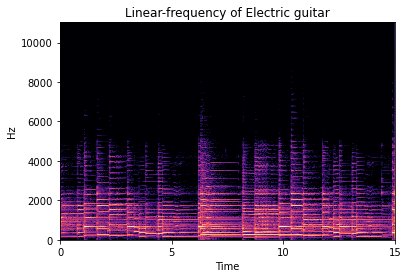

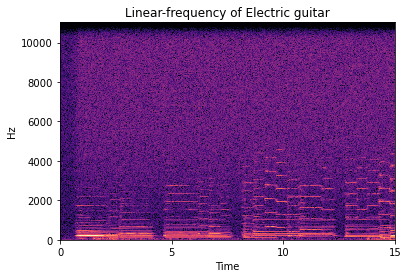

In [63]:
# Model 3 spectra of electric guitar randomly

for i in liste_pistes_electric :
    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency of Electric guitar')
    ax.label_outer()
    plt.show()

In [64]:
# We do the same procedure for acoustic guitar

acoustic_choice = random.choices(acoustic_stems, k = 3)
print("Our 3 tracks are : ", acoustic_choice)
clean_sampling_acoustic = ([s.split("_STEM")[0] for s in acoustic_choice])
clean_sampling_chiffre_acoustic = ([s.split("_0")[0] for s in acoustic_choice])

Our 3 tracks are :  ['Phoenix_ScotchMorris_STEM_01.wav', 'Phoenix_BrokenPledgeChicagoReel_STEM_01.wav', 'AlexanderRoss_VelvetCurtain_STEM_01.wav']


In [65]:
liste_pistes_acoustic = []
for i in range(0,3) :
    add_acoustic = Path.joinpath(audio_path, clean_sampling_acoustic[i], (clean_sampling_chiffre_acoustic[i])+'S', acoustic_choice[i])
    liste_pistes_acoustic.append(add_acoustic)

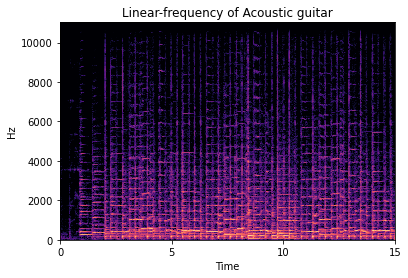

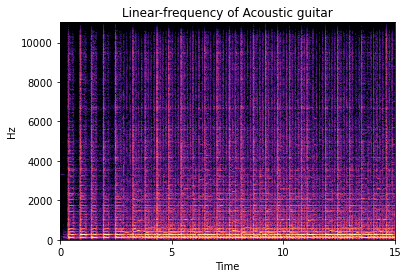

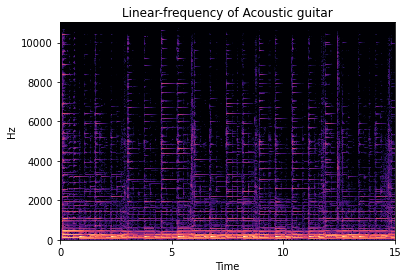

In [66]:
for i in liste_pistes_acoustic :

    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                sr=sr, ax=ax)
    ax.set(title='Linear-frequency of Acoustic guitar')
    ax.label_outer()
    plt.show()

In [73]:
# Decomposition of mix and tracks

def get_stems(track_name):

    # création du chemin vers les stems
    track_path = track_name + "_STEMS"
    stems_path = audio_path.joinpath(track_name, track_name + "_STEMS")
    # parcours des fichiers
    global stems_list
    stems_list = []
    for f in stems_path.glob('**/*.wav'):
        stems_list.append(f)
    track_stems = metadata_df.query(f"stem_dir == '{track_path}'")["stems"].iloc[0]
    track_stems = eval(track_stems)
    global instru_stems
    instru_stems = []
    # Parcours des instruments par pistes
    for s in track_stems.values():
        instru_stems.append(s["instrument"])
    
    return stems_list, instru_stems

In [84]:
# read audio samples
def get_audio(track_name):
    
    get_stems(track_name)
    plt.figure(figsize=(20,10))

    for i, s in enumerate(stems_list):
        audio, _ = librosa.load(s)
        plt.plot(audio[0:1500], label = instru_stems[i])
        plt.legend(framealpha=1, frameon=True)

    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.title("Sample Wav")
    plt.show()

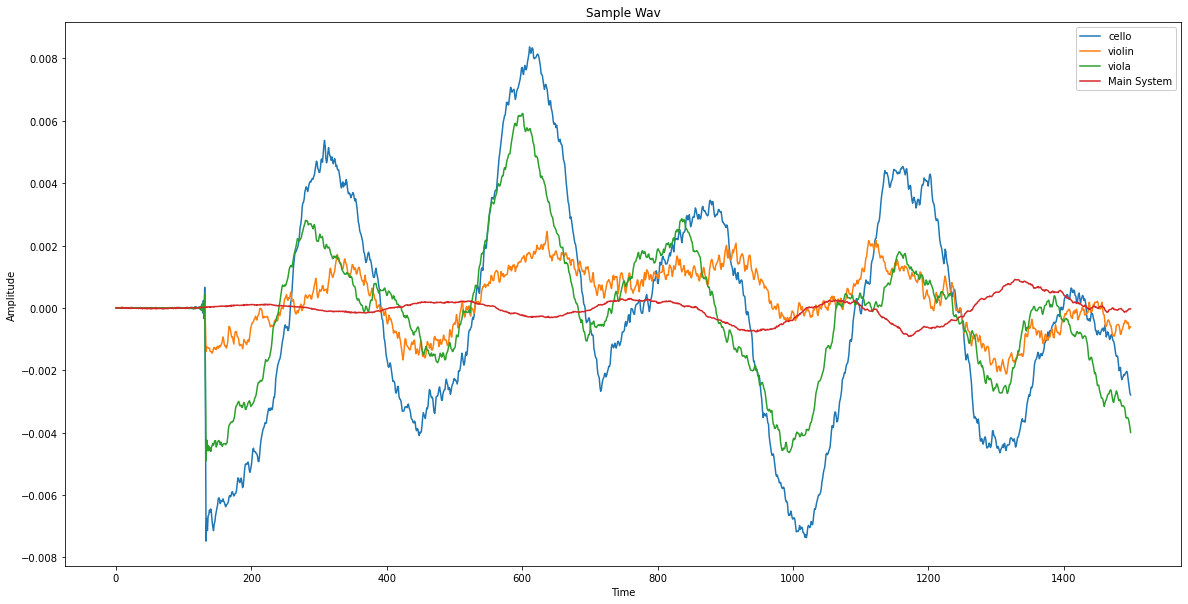

In [85]:
get_audio('AmadeusRedux_SchubertMovement2')

In [70]:
# TEST décomposition d'un mix et de ses stems
def get_linear_frequency(track_name):

    stems_list, instru_stems = get_stems(track_name)

    stems_path_mix = audio_path.joinpath(track_name, track_name + "_MIX.wav")

    y, sr = librosa.load(stems_path_mix, duration=30)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram of mix')
    ax.label_outer()
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=len(instru_stems), figsize=(20,10), sharey= True)

    for i, ax in enumerate(axs) :
        y, sr = librosa.load(stems_list[i], duration=30)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
        ax.set(title=str(instru_stems[i]))
        ax.label_outer()
        fig.suptitle('Linear fraquency of : ')

    plt.show()   

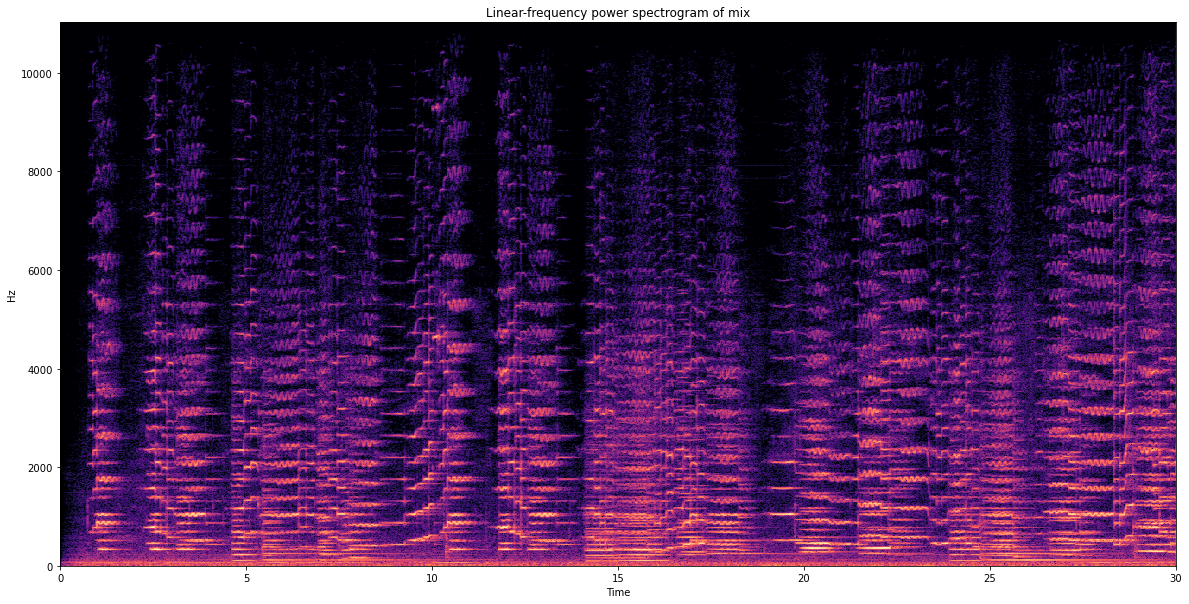

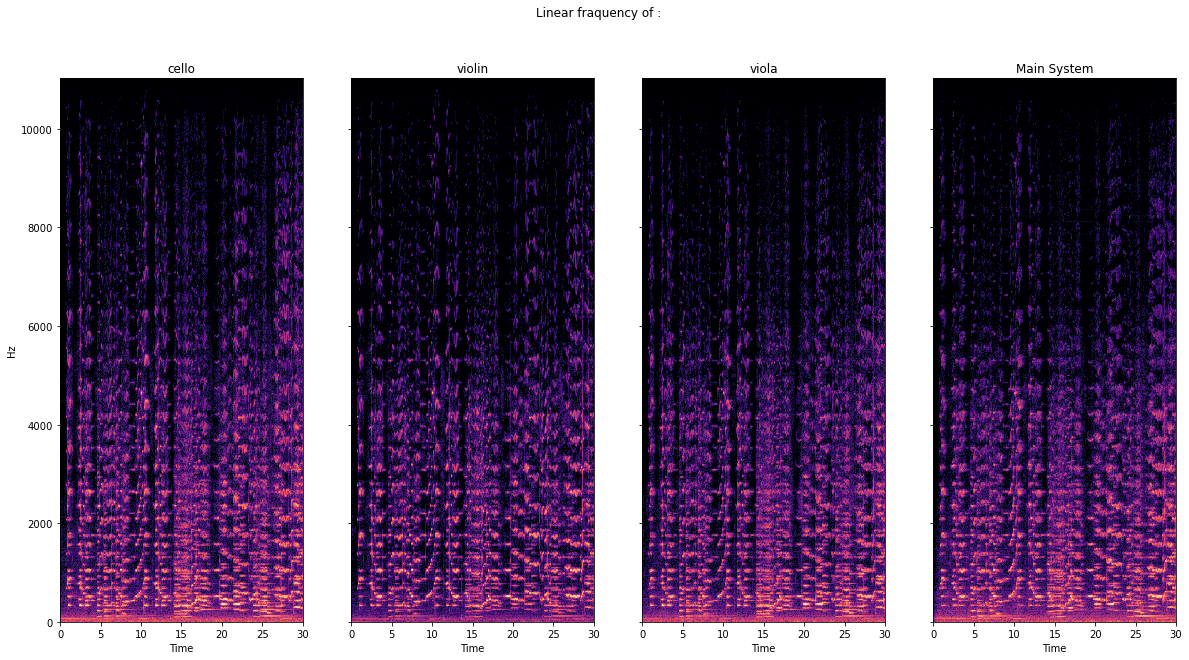

In [71]:
get_linear_frequency('AmadeusRedux_SchubertMovement2')